In [1]:
import matplotlib.pyplot as plt
import skimage.morphology
import pandas as pd
import numpy as np
import skimage
import torch
import glob
import re

In [2]:
fs = 400641.025641026

In [3]:
#%matplotlib notebook

In [4]:
plt.rcParams["figure.figsize"] = 8, 8 

In [5]:
path = './Data/316L/Gain_10_high_distance/Big_Cyl_316L/'

In [6]:
def parseData(path, sorting=True):
    channels = glob.glob(path + "/*/")
    print("These are the channels I found: ")
    print(channels)
    
    starting_GT = pd.read_csv(path+'/starting_GT.csv', sep=',',header=None).values
    ending_GT   = pd.read_csv(path+'/ending_GT.csv', sep=',',header=None).values

    dataAllChann = []
    for channel in channels:
        print("I'm working on this: ", channel)
        allFiles = glob.glob(channel + "/*.csv")
        if sorting:
            allFiles = sorted(allFiles, key=lambda x:float(re.findall("(\d+)",x)[-1]))
        dataSingleChan = []
        names = []
        for file in allFiles:
            signal = pd.read_csv(file, sep=',',header=None).values
            singleFile = torch.from_numpy(signal).view(1, 1, -1)
            dataSingleChan.append(singleFile)
            names.append(file)
        dataSingleChanTorch = torch.cat(dataSingleChan, 0)
        dataAllChann.append(dataSingleChanTorch)
    dataAllChannTorch = torch.cat(dataAllChann, 1)
    return dataAllChannTorch.numpy(), names, starting_GT, ending_GT

In [7]:
data, name, starting_GT, ending_GT = parseData(path)

These are the channels I found: 
['./Data/316L/Gain_10_high_distance/Big_Cyl_316L\\channel_0\\', './Data/316L/Gain_10_high_distance/Big_Cyl_316L\\channel_1\\', './Data/316L/Gain_10_high_distance/Big_Cyl_316L\\channel_2\\', './Data/316L/Gain_10_high_distance/Big_Cyl_316L\\channel_3\\']
I'm working on this:  ./Data/316L/Gain_10_high_distance/Big_Cyl_316L\channel_0\
I'm working on this:  ./Data/316L/Gain_10_high_distance/Big_Cyl_316L\channel_1\
I'm working on this:  ./Data/316L/Gain_10_high_distance/Big_Cyl_316L\channel_2\
I'm working on this:  ./Data/316L/Gain_10_high_distance/Big_Cyl_316L\channel_3\


In [8]:
signal_duration = (ending_GT[-1]-starting_GT[0])*1/fs
print('Signal duration [s]: ', signal_duration)

Signal duration [s]:  [2.31668986]


In [9]:
def computeBoundaries(signal, th):

    locs = np.where(signal>th)[0]

    indexes = np.zeros((signal.shape[0],1));
    indexes[locs] = 1;

    closed = skimage.morphology.closing(indexes, selem=torch.ones(120,1).numpy())
    opened = skimage.morphology.opening(closed, selem=torch.ones(120,1).numpy())


    locsNew = np.where(opened==1)
    locsNew = locsNew[0]


    derNew = np.diff(locsNew)

    ind = np.where(derNew>1)[0]

    ending = locsNew[ind]
    ending = np.append(ending,locsNew[-1])

    starting = locsNew[ind+1]
    starting = np.append(locsNew[0],starting)   
    return starting, ending

In [10]:
signal = data[0,0,:]

In [11]:
th = 0.0
starting, ending = computeBoundaries(signal, th)

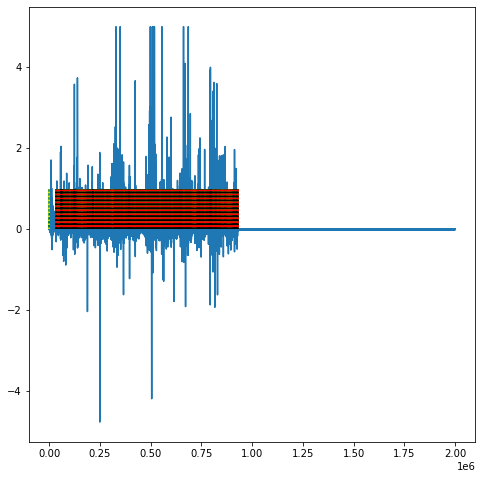

In [12]:
plt.figure()
plt.vlines(x=starting_GT, ymin=0, ymax=1, colors='green',zorder=10)
plt.vlines(x=ending_GT, ymin=0, ymax=1, colors='red',zorder=10)
plt.vlines(x=starting, ymin=0, ymax=1, colors='yellow',ls=':',zorder=1000)
plt.vlines(x=ending, ymin=0, ymax=1, colors='black',ls=':',zorder=1000)
plt.plot(signal)

In [13]:
def binarize_signals2(size, starting, ending):
    binary_sig = np.zeros((size,))

    for start, end in zip(starting, ending):
        binary_sig[np.arange(start=start, stop=end+1)] = 1

    
    return np.array(binary_sig, dtype=bool)

In [14]:
def calculateIoU(size, starting, ending, starting_GT, ending_GT):
    bool_sig = binarize_signals2(signal.shape[0], starting, ending)
    bool_sig_GT = binarize_signals2(signal.shape[0], starting_GT, ending_GT)
    
    intersection = np.logical_and(bool_sig, bool_sig_GT)
    union = np.logical_or(bool_sig, bool_sig_GT)

    intersection_area = np.sum(intersection)
    union_area = np.sum(union)

    IoU = intersection_area/union_area*100
    
    return IoU

In [15]:
def IoUforTh(size, thresholded, starting_GT, ending_GT):
    bool_sig_GT = binarize_signals2(signal.shape[0], starting_GT, ending_GT)

    intersection = np.logical_and(thresholded, bool_sig_GT)
    union = np.logical_or(thresholded, bool_sig_GT)

    intersection_area = np.sum(intersection)
    union_area = np.sum(union)

    IoU = intersection_area/union_area*100
    
    return IoU

In [16]:
IoU = calculateIoU(signal.shape[0], starting, ending, starting_GT, ending_GT)
IoU

99.96736526981381

In [17]:
def computeThreshold(signal, th):

    locs = np.where(signal>th)[0]

    indexes = np.zeros((signal.shape[0],));
    indexes[locs] = 1;
    
    return np.array(indexes, dtype=bool)

In [18]:
def computeprecrecallMM(size, starting, ending, starting_GT, ending_GT):
    bool_sig = binarize_signals2(size, starting, ending)
    bool_sig_GT = binarize_signals2(size, starting_GT, ending_GT)

    prec = np.sum(bool_sig_GT*bool_sig)/np.sum(bool_sig)
    recall = np.sum(bool_sig_GT*bool_sig)/(np.sum(bool_sig_GT*bool_sig)+np.sum(np.logical_not(bool_sig)*bool_sig_GT))
    return prec, recall
def computeprecrecallTh(size, thresholded, starting_GT, ending_GT):
    bool_sig_GT = binarize_signals2(size, starting_GT, ending_GT)

    prec = np.sum(bool_sig_GT*thresholded)/np.sum(thresholded)
    recall = np.sum(bool_sig_GT*thresholded)/(np.sum(thresholded*bool_sig_GT)+
                                              np.sum(np.logical_not(thresholded)*bool_sig_GT))
    return prec, recall

In [19]:
thresholded = computeThreshold(signal, th=0)
IoU = IoUforTh(signal.shape[0], thresholded, starting_GT, ending_GT)
IoU

95.42702502736245

In [20]:
ths = np.linspace(start=0.0, stop=0.31, num=100)
ths

array([0.        , 0.00313131, 0.00626263, 0.00939394, 0.01252525,
       0.01565657, 0.01878788, 0.02191919, 0.02505051, 0.02818182,
       0.03131313, 0.03444444, 0.03757576, 0.04070707, 0.04383838,
       0.0469697 , 0.05010101, 0.05323232, 0.05636364, 0.05949495,
       0.06262626, 0.06575758, 0.06888889, 0.0720202 , 0.07515152,
       0.07828283, 0.08141414, 0.08454545, 0.08767677, 0.09080808,
       0.09393939, 0.09707071, 0.10020202, 0.10333333, 0.10646465,
       0.10959596, 0.11272727, 0.11585859, 0.1189899 , 0.12212121,
       0.12525253, 0.12838384, 0.13151515, 0.13464646, 0.13777778,
       0.14090909, 0.1440404 , 0.14717172, 0.15030303, 0.15343434,
       0.15656566, 0.15969697, 0.16282828, 0.1659596 , 0.16909091,
       0.17222222, 0.17535354, 0.17848485, 0.18161616, 0.18474747,
       0.18787879, 0.1910101 , 0.19414141, 0.19727273, 0.20040404,
       0.20353535, 0.20666667, 0.20979798, 0.21292929, 0.21606061,
       0.21919192, 0.22232323, 0.22545455, 0.22858586, 0.23171

In [21]:
IoUsMM  = []
IoUsTh  = []
precsMM = []
recallsMM = []
precsTh = []
recallsTh = []
for th in ths:
    thresholded = computeThreshold(signal, th)
    IoUTh = IoUforTh(signal.shape[0], thresholded, starting_GT, ending_GT)
    precTh, recallTh = computeprecrecallTh(signal.shape[0], thresholded, starting_GT, ending_GT)
    IoUsTh.append(IoUTh)
    precsTh.append(precTh)
    recallsTh.append(recallTh)
    starting, ending = computeBoundaries(signal, th)
    IoUMM = calculateIoU(signal.shape[0], starting, ending, starting_GT, ending_GT)
    precMM, recallMM = computeprecrecallMM(signal.shape[0], starting, ending, starting_GT, ending_GT)
    IoUsMM.append(IoUMM)
    precsMM.append(precMM)
    recallsMM.append(recallMM)

Text(0.5, 1.0, 'IoU')

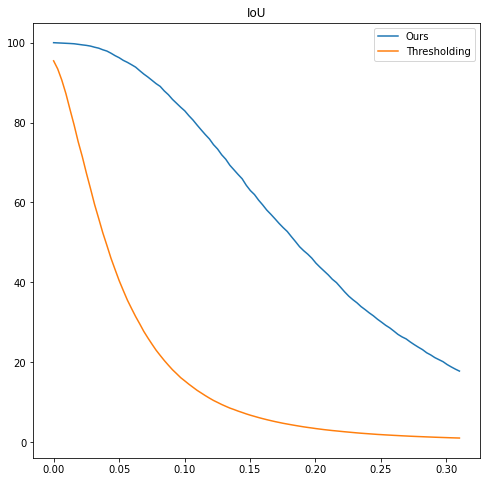

In [22]:
plt.figure()
plt.plot(ths, IoUsMM, label='Ours')
plt.plot(ths, IoUsTh, label='Thresholding')
plt.legend()
plt.title('IoU')

Text(0.5, 1.0, 'Precision')

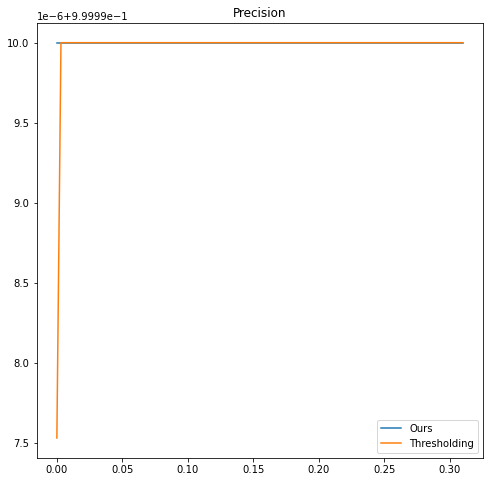

In [23]:
plt.figure()
plt.plot(ths, precsMM, label='Ours')
plt.plot(ths, precsTh, label='Thresholding')
plt.legend()
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

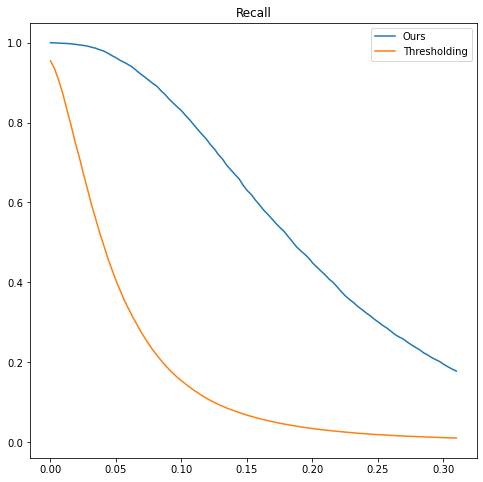

In [24]:
plt.figure()
plt.plot(ths, recallsMM, label='Ours')
plt.plot(ths, recallsTh, label='Thresholding')
plt.legend()
plt.title('Recall')

In [25]:
precsMM, recallsMM = np.array(precsMM), np.array(recallsMM)
precsTh, recallsTh = np.array(precsTh), np.array(recallsTh)

F1_scoreMM = 2 * (precsMM * recallsMM)/ (precsMM + recallsMM)
F1_scoreTh = 2 * (precsTh * recallsTh)/ (precsTh + recallsTh)

Text(0.5, 1.0, '$F_1$-score')

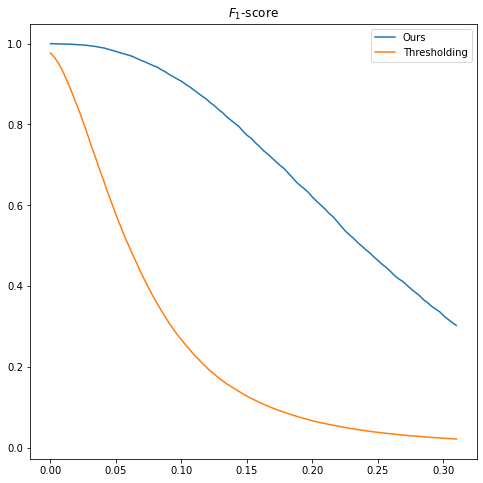

In [26]:
plt.figure()
plt.plot(ths, F1_scoreMM, label='Ours')
plt.plot(ths, F1_scoreTh, label='Thresholding')
plt.legend()
plt.title('$F_1$-score')